# UCCS Visualize

- read in all images, resized
- mean images
- read in all bboxes
- draw normalized bboxes

In [2]:
%reload_ext autoreload
%autoreload 2

import os
from os.path import join
import math
from glob import glob
from random import randint

import cv2 as cv
import numpy as np
import pandas as pd
from PIL import Image, ImageDraw
%matplotlib inline
import matplotlib.pyplot as plt
import scipy.io
from pathlib import Path
from sklearn import preprocessing
from tqdm import tqdm_notebook as tqdm

import sys
sys.path.append('/work/megapixels_dev/megapixels/')
from app.settings import app_cfg as cfg
from app.utils import file_utils
from app.models.bbox import BBox

In [3]:
fp_dir_uccs = '/data_store/datasets/people/uccs/dataset'
fp_dir_ims = '/data_store/datasets/people/uccs/dataset/media/original'
fp_baseline = '/data_store/datasets/people/uccs/dataset/UCCS-v2-detection-baseline-validation.csv'

In [4]:
# function to create spaced colormaps as RGB values

import matplotlib as mpl
import matplotlib.cm as mplcm
import matplotlib.pyplot as plt
from matplotlib import cm

def get_color_map(cmap='prism', ncolors=20, as_hex=False, reverse=False, bgr=True):
  norm  = mpl.colors.Normalize(vmin=0, vmax=ncolors-1)
  scalars = mplcm.ScalarMappable(norm=norm, cmap=cmap)
  colors = [scalars.to_rgba(i) for i in range(ncolors)]
  colors = [(int(255*c[0]),int(255*c[1]),int(255*c[2])) for c in colors]  
  if reverse:
    colors = colors[::-1]
  if bgr:
    colors = [c[::-1] for c in colors]
  if as_hex:
    colors = ['#{:02x}{:02x}{:02x}'.format(c[0],c[1],c[2]) for c in colors]
  return colors

def jitter_clr(clr, amt=10, mono=False):
  clr = list(clr)
  if mono:
    r = randint(-amt, amt)
    for i in range(len(clr)):
      clr[i] = max(0, min(255, clr[i] + r))
  else:
    for i in range(len(clr)):
      r = randint(-amt, amt)
      clr[i] = max(0, min(255, clr[i] + r))
  return clr

def random_color():
  return tuple(map(int, np.random.choice(range(256), size=3)))

In [5]:
fp_ims = glob(join(fp_dir_ims, '*.jpg'))
print(len(fp_ims))

10917


In [6]:
im = cv.imread(fp_ims[0])
print(im.shape)

(3456, 5184, 3)


In [7]:
df_rois = pd.read_csv(fp_baseline)
roi_records = df_rois.to_dict('records')
df_rois.head()

FILE     BB_X     BB_Y  BB_WIDTH  \
0  000b35e2c91ccd4adb25e7e410db7b7c.jpg  3540.81  1973.13    237.21   
1  000b35e2c91ccd4adb25e7e410db7b7c.jpg  1576.59  2290.10    189.79   
2  000b35e2c91ccd4adb25e7e410db7b7c.jpg   706.63  1512.31    180.06   
3  000d7f5f2b753210388273e792dae92b.jpg  2106.86  2868.81    226.57   
4  000d7f5f2b753210388273e792dae92b.jpg   -17.83  1933.80    125.03   

   BB_HEIGHT  DETECTION_SCORE  
0     287.37             0.99  
1     223.13             0.97  
2     254.76             0.55  
3     279.73             1.00  
4     214.81             1.00

In [8]:
rois = {}
dim = (5184, 3456)
for row in roi_records:
  x, y, w, h = row['BB_X'], row['BB_Y'], row['BB_WIDTH'], row['BB_HEIGHT']
  # threshold values for 5184x3456
  x = max(0, min(5184, x))
  y = max(0, min(y,3456))
  rois[row['FILE']] = BBox.from_xywh_dim(x, y, w, h, dim)
print(len(rois))

5232


In [71]:
colors = get_color_map(cmap='Blues', ncolors=len(rois), reverse=False, bgr=True)

 Colormap PiYGF is not recognized. Possible values are: Accent, Accent_r, Blues, Blues_r, BrBG, BrBG_r, BuGn, BuGn_r, BuPu, BuPu_r, CMRmap, CMRmap_r, Dark2, Dark2_r, GnBu, GnBu_r, Greens, Greens_r, Greys, Greys_r, OrRd, OrRd_r, Oranges, Oranges_r, PRGn, PRGn_r, Paired, Paired_r, Pastel1, Pastel1_r, Pastel2, Pastel2_r, PiYG, PiYG_r, PuBu, PuBuGn, PuBuGn_r, PuBu_r, PuOr, PuOr_r, PuRd, PuRd_r, Purples, Purples_r, RdBu, RdBu_r, RdGy, RdGy_r, RdPu, RdPu_r, RdYlBu, RdYlBu_r, RdYlGn, RdYlGn_r, Reds, Reds_r, Set1, Set1_r, Set2, Set2_r, Set3, Set3_r, Spectral, Spectral_r, Wistia, Wistia_r, YlGn, YlGnBu, YlGnBu_r, YlGn_r, YlOrBr, YlOrBr_r, YlOrRd, YlOrRd_r, afmhot, afmhot_r, autumn, autumn_r, binary, binary_r, bone, bone_r, brg, brg_r, bwr, bwr_r, cividis, cividis_r, cool, cool_r, coolwarm, coolwarm_r, copper, copper_r, cubehelix, cubehelix_r, flag, flag_r, gist_earth, gist_earth_r, gist_gray, gist_gray_r, gist_heat, gist_heat_r, gist_ncar, gist_ncar_r, gist_rainbow, gist_rainbow_r, gist_stern, gist_stern_r, gist_yarg, gist_yarg_r, gnuplot, gnuplot2, gnuplot2_r, gnuplot_r, gray, gray_r, hot, hot_r, hsv, hsv_r, inferno, inferno_r, jet, jet_r, magma, magma_r, nipy_spectral, nipy_spectral_r, ocean, ocean_r, pink, pink_r, plasma, plasma_r, prism, prism_r, rainbow, rainbow_r, seismic, seismic_r, spring, spring_r, summer, summer_r, tab10, tab10_r, tab20, tab20_r, tab20b, tab20b_r, tab20c, tab20c_r, terrain, terrain_r, viridis, viridis_r, winter, winter_r

In [67]:
random_color()

(232, 126, 182)

In [68]:
print(list(rois.values())[2])

BBox: (0.1759008487654321,0.7841435185185185), (0.2050906635802469, 0.8471296296296296), width:0.029189814814814807, height:0.06298611111111108


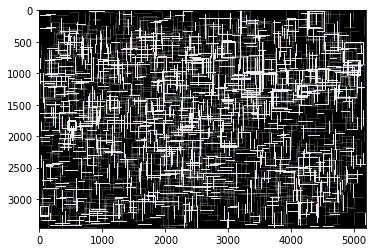

In [90]:
# draw it
scale = 1
ya_green = (250,250,250)
size_orig = (5184, 3456)
size_scale = (int(size_orig[0]/scale), int(size_orig[1]/scale))
im = np.zeros([size_scale[1], size_scale[0], 3]).astype(np.uint8)
im_blank = im.copy()
im[::] = (0,0,0)
limit = 12000
# limit = 100
stroke_weight = 1

w,h = size_scale
for i, roi in enumerate(tqdm(rois.items())):
  fname, bbox = roi  # expand
  bbox = bbox.to_dim((w,h))
  pt1, pt2 = tuple(map(int, bbox.pt_tl)), tuple(map(int, bbox.pt_br))
  #im_cp = im.copy()
  rn = random_color()
  #cv.rectangle(im, pt1, pt2, jitter_clr(colors[i]), stroke_weight, cv.LINE_AA,)
  cv.rectangle(im, pt1, pt2, jitter_clr(ya_green), stroke_weight, cv.LINE_AA)
  #im = cv.addWeighted(im_cp, 0.9, im, .1, 0)
  if i > limit:
    break

    
cv.imwrite('bboxes_full_03.png', im)
plt.imshow(cv.cvtColor(im, cv.COLOR_BGR2RGB))

In [108]:
from time import sleep

In [110]:
for j in tqdm(range(100), desc='2nd loop'):
  sleep(0.01)